In [ ]:
%pip install tensorflow

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

### Why ResNets?
When training neural networks, in theory, the more layers you have the better the performance is going to be. In practice, that's not true, this happens because, the deeper you go into the neural networks, the higher the chances your gradients vanish/explode, this makes it difficult for the network to learn effectively.

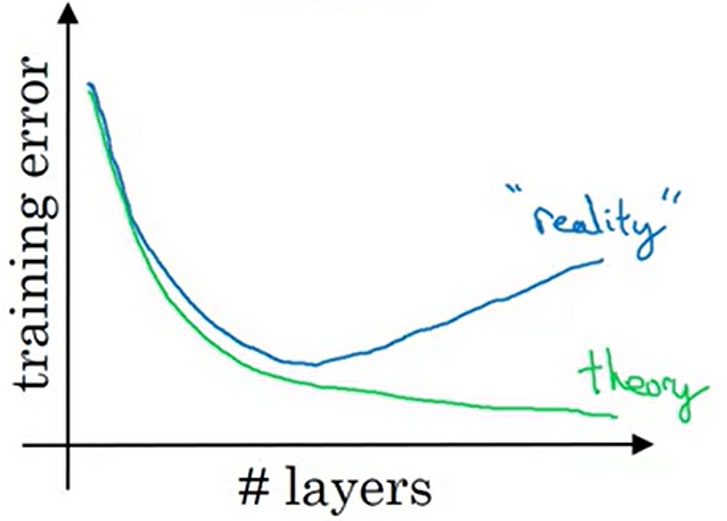

### How ResNets works?

In a standard feedforward network, each layer's output is passed through an activation function. However, in ResNet, instead of directly using the output of the current layer, the feature map from a previous layer is added to the current layer's output before applying the activation function. This creates what is known as a **residual connection** or **skip connection**. 
The intuition behind this is that it allows the network to learn the identity function if necessary. In the worst case, it can simply learn the previous layer's output, preventing the network from becoming worse as more layers are added. This also allows the network to learn more complex functions without losing the ability to learn simpler ones. <br>

The mathematical foundation for this looks like:  

<div style="margin-left: 50px">
    $a^{[l+1]} = \text{ReLU}(w^{[l+1]}a^{[l]} + b^{[l+1]})$
</div>

Then, with a residual connection added:  

<div style="margin-left: 50px">
    $a^{[l+2]} = \text{ReLU}(w^{[l+2]}a^{[l+1]} + b^{[l+2]} + a^{[l]})$
</div>

If $w^{[l+2]} = 0$ and $b^{[l+2]} = 0$, it simplifies to:  

<div style="margin-left: 50px">
    $a^{[l+2]} = \text{ReLU}(a^{[l]}) = a^{[l]}$
</div>  

Where a is the output of the l-th layer, w and b are its parameters.   
This behavior ensures that the network doesn't degrade as it gets deeper, and it can maintain or improve its performance as additional layers are added.  

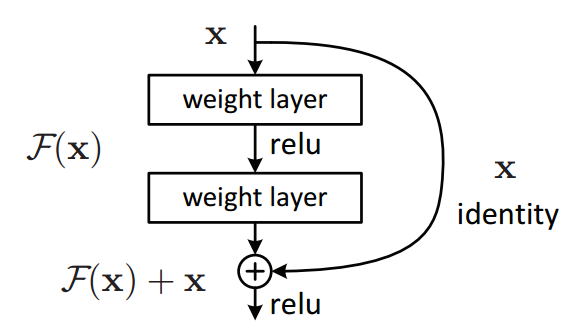

In [2]:
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding="same", use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.Activation("relu")
        
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding="same", use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.Activation("relu")

        self.need_to_use_projection = stride != 1
        if self.need_to_use_projection:
            self.projection = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same", use_bias=False)
            self.bn_proj = tf.keras.layers.BatchNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.need_to_use_projection:
            shortcut = self.projection(inputs)
            shortcut = self.bn_proj(shortcut)
        else:
            shortcut = inputs

        # Add skip connection
        x += shortcut
        return self.relu2(x)

In [5]:
def create_resnet_model(num_classes):
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(16, kernel_size=3, strides=1, padding="same", use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = ResNetBlock(16)(x)
    x = ResNetBlock(16)(x)
    x = ResNetBlock(32, stride=2)(x)
    x = ResNetBlock(32)(x)
    x = ResNetBlock(32)(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=7)(x)
    
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(units=num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

### Evaluating the model
To test the model, I'll be using the MNIST dataset, besides normalizing the inputs, no other data preprocessing is done

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

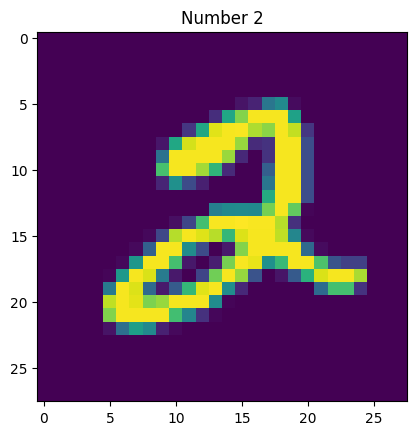

In [7]:
sample = 5
plt.title(label=f"Number {y_train[sample]}")
plt.imshow(x_train[sample])

In [ ]:
num_classes = 10

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [6]:
model = create_resnet_model(num_classes)

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block (ResNetBlock)     │ (None, 28, 28, 16)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_1 (ResNetBlock)   │ (None, 28, 28, 16)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_2 (ResNetBlock)   │ (None, 14, 14, 32)     │        14,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_3 (ResNetBlock)   │ (None, 14, 14, 32)     │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_block_4 (ResNetBlock)   │ (None, 14, 14, 32)     │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,066 (246.35 KB)

 Trainable params: 62,458 (243.98 KB)

 Non-trainable params: 608 (2.38 KB)

### Training
Used Adam as the optimization algorithm and the Categorical Crossentropy loss, as we are using the softmax activation as output. Mini-batch size of 128. Started training with a learning rate of 0.001, once the model plateaued, I reduced it to 0.0001

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [32]:
model.fit(x=x_train, y=y_train, batch_size=128, epochs=1, validation_split=0.15)

399/399 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9990 - loss: 0.0045 - val_accuracy: 0.9939 - val_loss: 0.0216


In [33]:
loss, accuracy = model.evaluate(x=x_test, y=y_test)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {(accuracy*100):.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9926 - loss: 0.0189
Loss: 0.01
Accuracy: 99.45%


In [34]:
model.save("model.keras")